# Getting Started with Dynamic Mode

## Dynamic Mode

In dynamic mode, you work with DALI operators as functions that you can call directly. There's no need to define a computation graph upfront - you simply call operators and get results. This offers more flexibility than pipeline mode, making it easier to integrate DALI into existing code and to experiment with different processing steps.

### Reading and decoding images

Let us start with defining a very simple task for a classification problem: determining whether a picture contains a dog or a kitten. We prepared a directory structure containing pictures of dogs and kittens [in our repository](https://github.com/NVIDIA/DALI/tree/master/docs/examples/data/images).

We will read images from this directory, and decode them as follows:

  1. Create a file reader with `ndd.readers.File`.
  2. Iterate over the reader using `next_epoch()` to get batches of jpegs (encoded images) and labels from the hard drive.
  3. Decode images with `ndd.decoders.image`.

In [1]:
import nvidia.dali.experimental.dynamic as ndd
import nvidia.dali.types as types

image_dir = "../data/images"
batch_size = 8

reader = ndd.readers.File(file_root=image_dir)
for jpegs, labels in reader.next_epoch(batch_size=batch_size):
    images = ndd.decoders.image(jpegs, device="cpu")
    break

print(f"Batch of {images.batch_size} images")
print(f"First image shape: {images.shape[0]}")

Batch of 8 images
First image shape: (427, 640, 3)


Passing a batch size to `next_epoch` causes it to yield batches instead of tensors. `ndd.decoders.image` in turns returns a batch if its input it a batch, so both `images` and `labels` are `Batch` objects.

<div class="alert alert-warning">

   Warning<br>
   
   `Batch` objects are not directly indexable. Use `batch.select(n)` to get a single sample.
   
   Alternatively, `batch.slice[start, stop, end]` can be used for samplewise slicing.
   
</div>

### Visualizing Results

In order to see the images, we will define a helper function that loops over all samples in the batch.

In [2]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

%matplotlib inline


def show_images(images: ndd.Batch):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(24, (24 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(images.select(j))

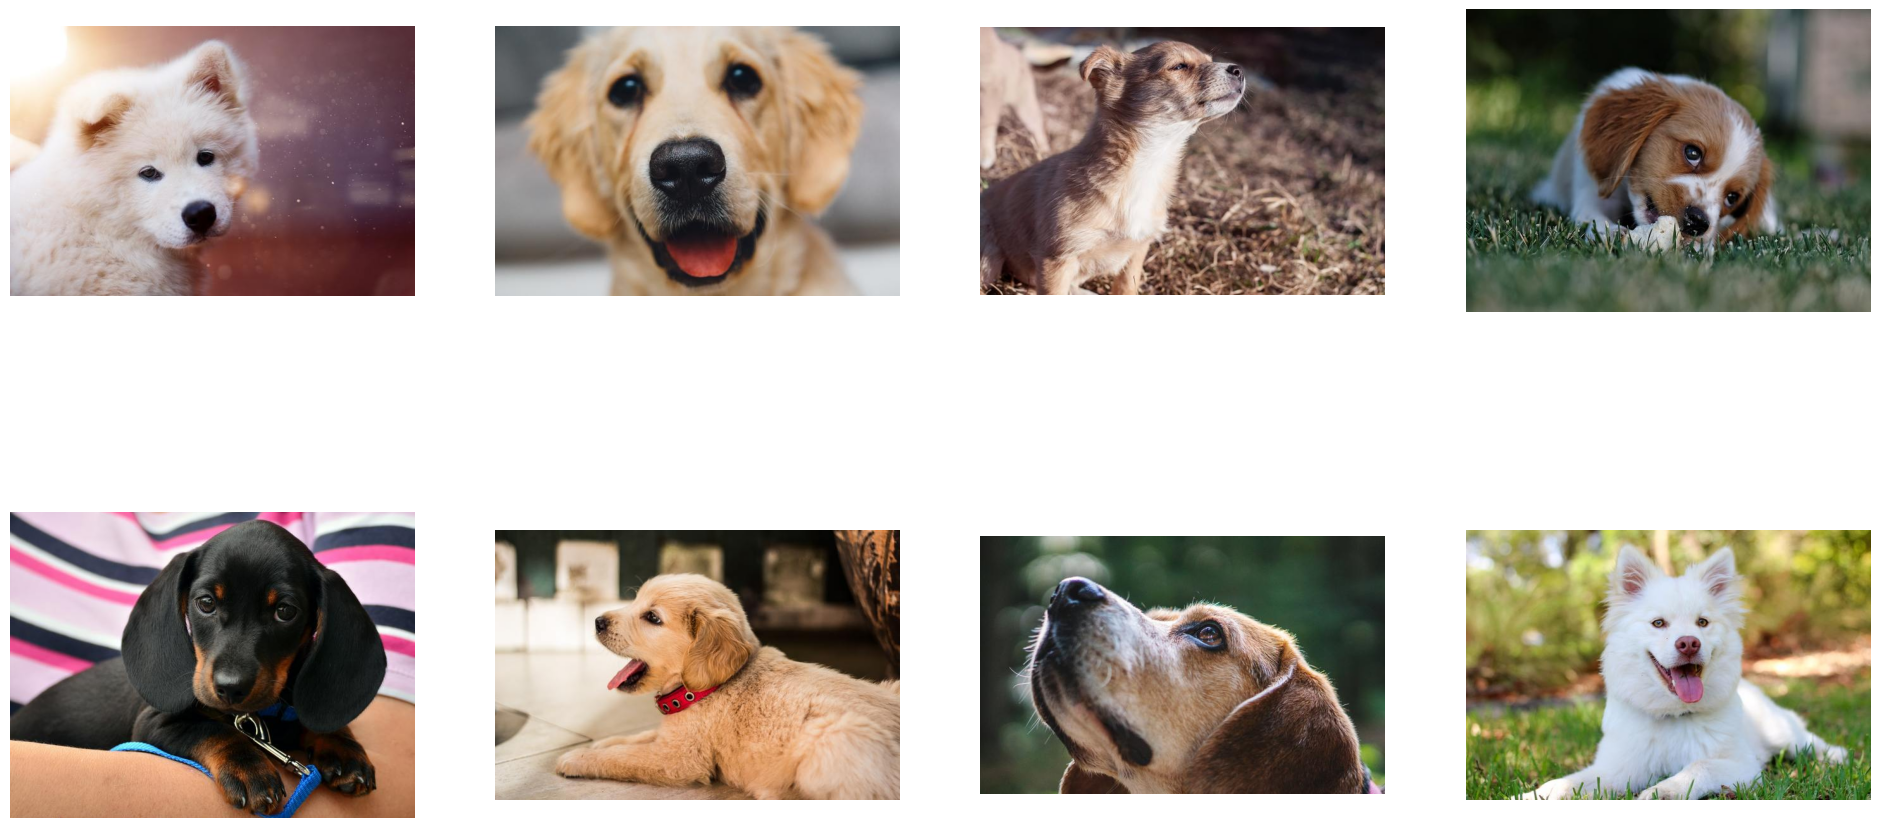

In [3]:
show_images(images)

## Adding Augmentations

### Random Shuffle

As we can see from the example above, the first batch of images returned contains only dogs. That is because we did not shuffle our dataset, and so `ndd.readers.File` returns images in lexicographic order.

Let us create a new reader with shuffling enabled.

In [4]:
shuffled_reader = ndd.readers.File(file_root=image_dir, random_shuffle=True, initial_fill=21)

for jpegs, labels in shuffled_reader.next_epoch(batch_size=batch_size):
    images = ndd.decoders.image(jpegs, device="cpu")
    break

We added 2 arguments to the reader's constructor:

* `random_shuffle` enables shuffling of images in the reader. Shuffling is performed by using a buffer of images read from disk. When the reader is asked to provide the next image, it randomly selects an image from the buffer, outputs it and immediately replaces that spot in the buffer with a freshly read image.
* `initial_fill` sets the capacity of the buffer. The default value of this parameter (1000), well suited for datasets containing thousands of examples, is too big for our very small dataset, which contains only 21 images. This could result in frequent duplicates in the returned batch. That is why in this example we set it to the size of our dataset.
 
Let us test the result of this modification.

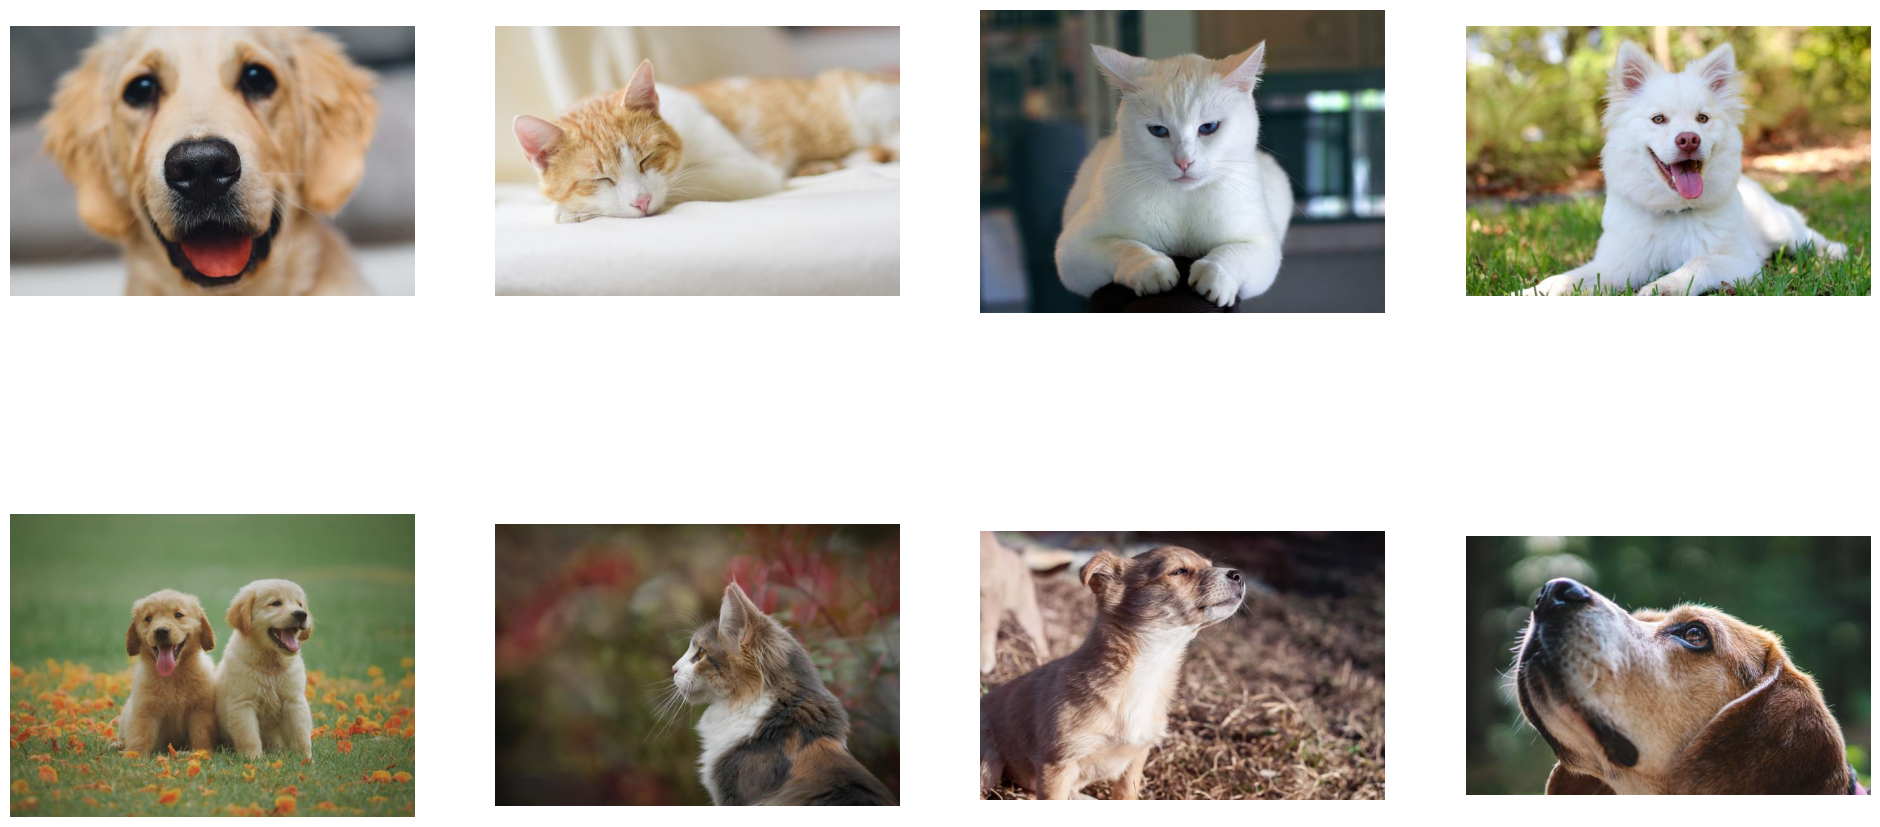

In [5]:
show_images(images)

Now the images returned are shuffled properly.

### Augmentations

DALI can not only read images from disk and batch them into tensors, it can also perform various augmentations on those images to improve Deep Learning training results.

One example of such augmentations is rotation. Let us rotate the images by a fixed angle using `ndd.rotate`.

In [6]:
reader = ndd.readers.File(file_root=image_dir, random_shuffle=True, initial_fill=21)

for jpegs, labels in reader.next_epoch(batch_size=batch_size):
    images = ndd.decoders.image(jpegs, device="cpu")
    rotated_images = ndd.rotate(images, angle=10.0, fill_value=0)
    break

As we can see in the [documentation](../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.rotate.html), `rotate` can take multiple arguments, but only one of them beyond `input` is required - `angle` tells the operator how much it should rotate images. We also specified `fill_value` to better visualise the results.

Let us test the result.

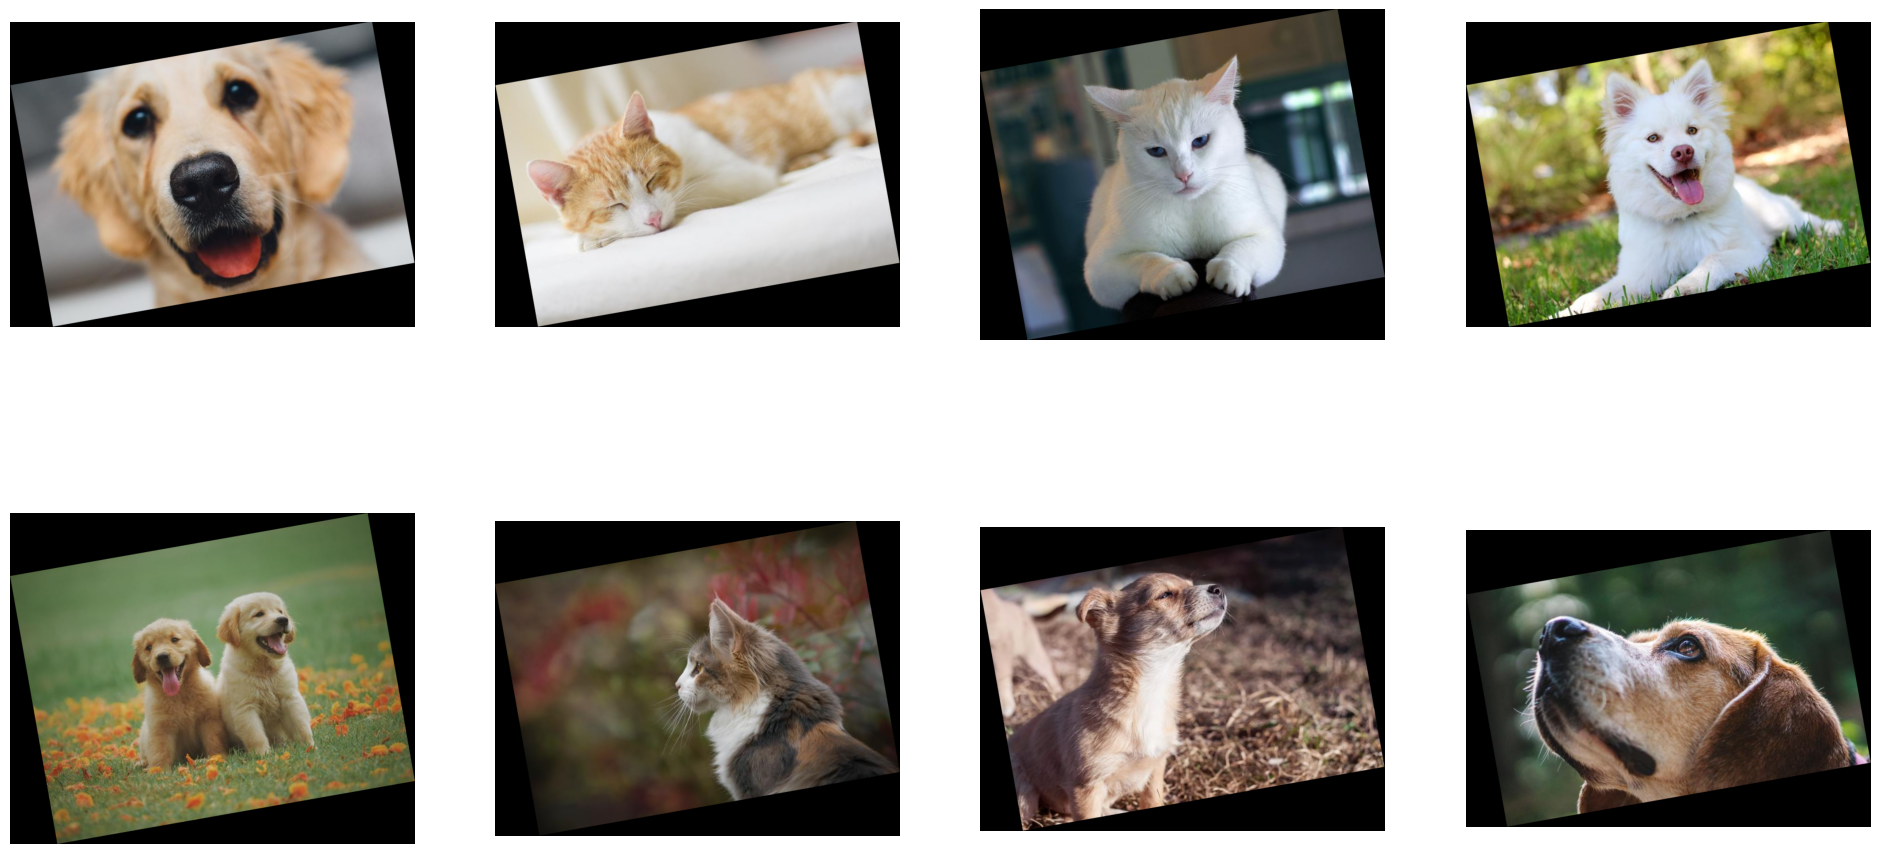

In [7]:
show_images(rotated_images)

### Tensors as Arguments and Random Number Generation


Rotating every image by 10 degrees is not that interesting. To make a meaningful augmentation, we would like an operator that rotates our images by a random angle in a given range. 

Rotate's `angle` parameter can accept a `float` or a `Tensor`/`Batch` of `float`. The second option enables us to feed the operator with different rotation angles for every image, via a tensor or batch produced by another operation.

Random number generators are examples of operations that one can use with DALI. Let us use `ndd.random.uniform` to rotate each image by a random angle.

<div class="alert alert-info">
    
  Note<br>
    
  Keep in mind, that every time you pass an output of a DALI operator to another as a named keyword argument that data must be placed on the CPU. In the example below, we use the output of `random.uniform` as `angle` keyword argument to `rotate`.

  Such arguments in DALI are called "argument inputs". More information about them can be found in the [pipeline mode documentation](../../pipeline.html?#processing-graph-structure).

  Regular inputs (non-named, positional ones) do not have such constraints and can use either CPU or GPU data, as shown below.
</div>

In [8]:
reader = ndd.readers.File(file_root=image_dir, random_shuffle=True, initial_fill=21)

for jpegs, labels in reader.next_epoch(batch_size=batch_size):
    images = ndd.decoders.image(jpegs, device="cpu")
    angles = ndd.random.uniform(batch_size=batch_size, range=(-10, 10))
    random_rotated_images = ndd.rotate(images, angle=angles, fill_value=0)
    break

This time, instead of providing a fixed value for the `angle` argument, we set it to the output of the random operator.

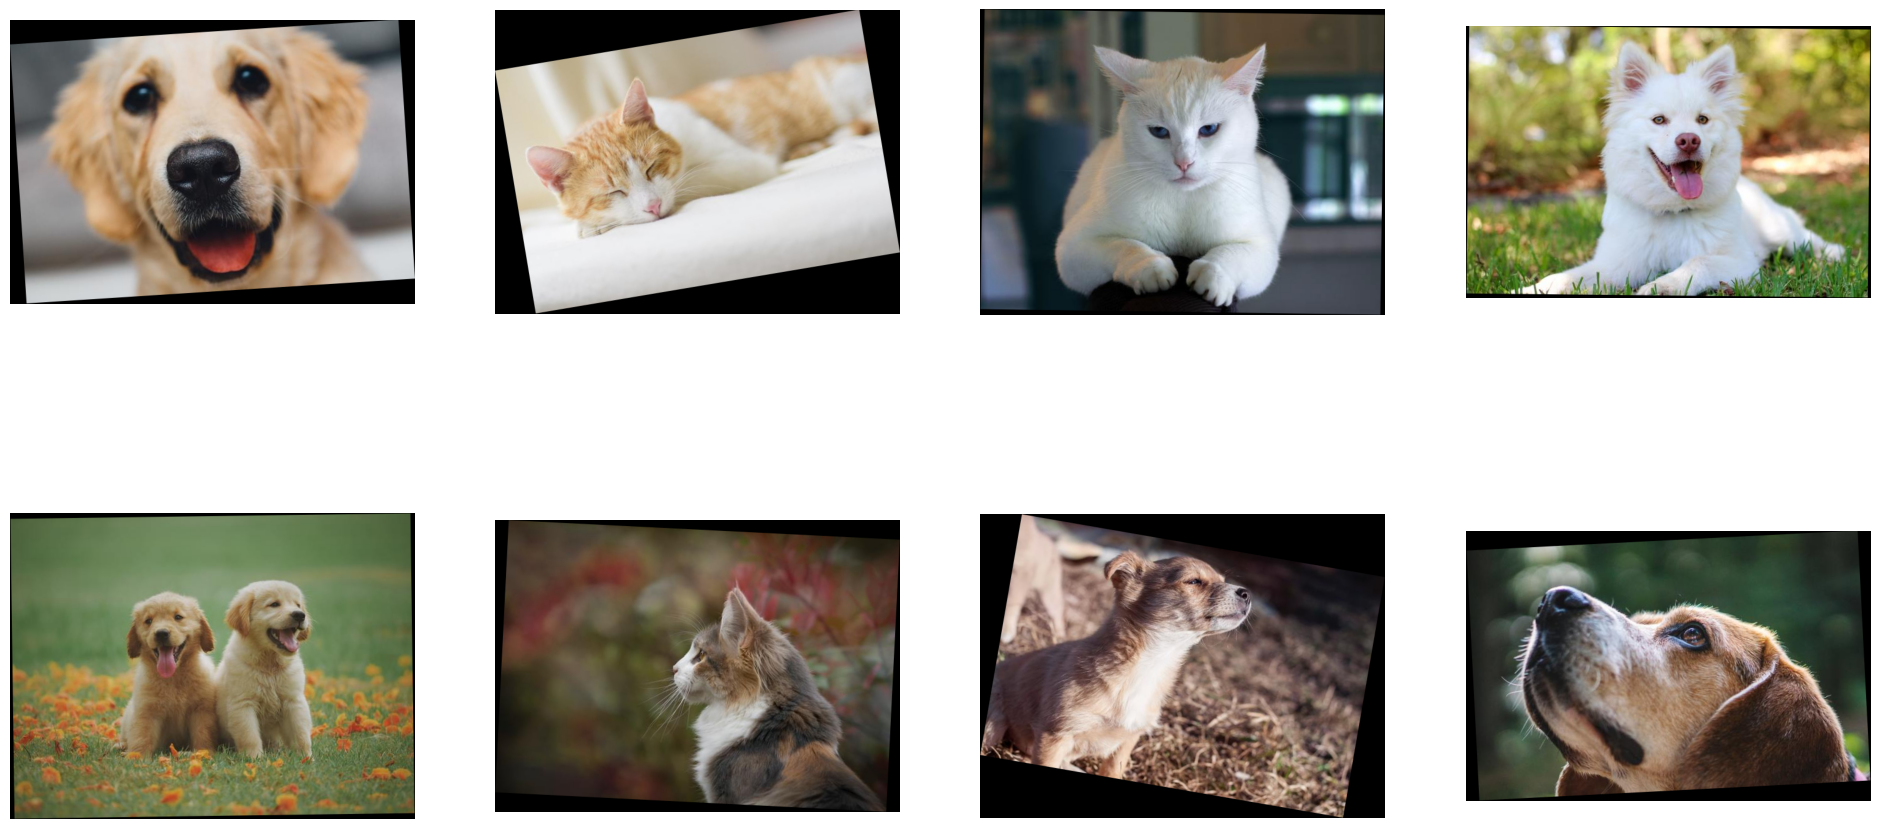

In [9]:
show_images(random_rotated_images)

The rotation angle is now randomly selected from a value range.

## Adding GPU Acceleration

DALI offers access to GPU accelerated operators, that can increase the speed of the input and augmentation pipeline and let it scale to multi-GPU systems.

### Moving Data to GPU

Let us modify the previous example to use the GPU for the rotation.

In [10]:
reader = ndd.readers.File(file_root=image_dir, random_shuffle=True, initial_fill=21)

for jpegs, labels in reader.next_epoch(batch_size=batch_size):
    images = ndd.decoders.image(jpegs, device="cpu")
    angles = ndd.random.uniform(batch_size=batch_size, range=(-10, 10))
    random_rotated_images = ndd.rotate(images.gpu(), angle=angles, fill_value=0)
    break

In order to tell DALI that we want to use the GPU, we needed to make only one change to the pipeline. We changed input to the rotate operation from `images`, which is a batch on the CPU, to `images.gpu()` which copies it to the GPU.

In [11]:
print(random_rotated_images.select(0))

Tensor(
TensorGPU(
    [[[0 0 0]
      [0 0 0]
      ...
      [0 0 0]
      [0 0 0]]

     [[0 0 0]
      [0 0 0]
      ...
      [0 0 0]
      [0 0 0]]

     ...

     [[0 0 0]
      [0 0 0]
      ...
      [0 0 0]
      [0 0 0]]

     [[0 0 0]
      [0 0 0]
      ...
      [0 0 0]
      [0 0 0]]],
    dtype=DALIDataType.UINT8,
    layout=HWC,
    shape=[527, 702, 3]))


This time, the rotated images are located on the GPU. We cannot access contents of a GPU tensor or batch directly from the CPU, so in order to visualize the result we need to copy it to the CPU by using the `cpu()` method.

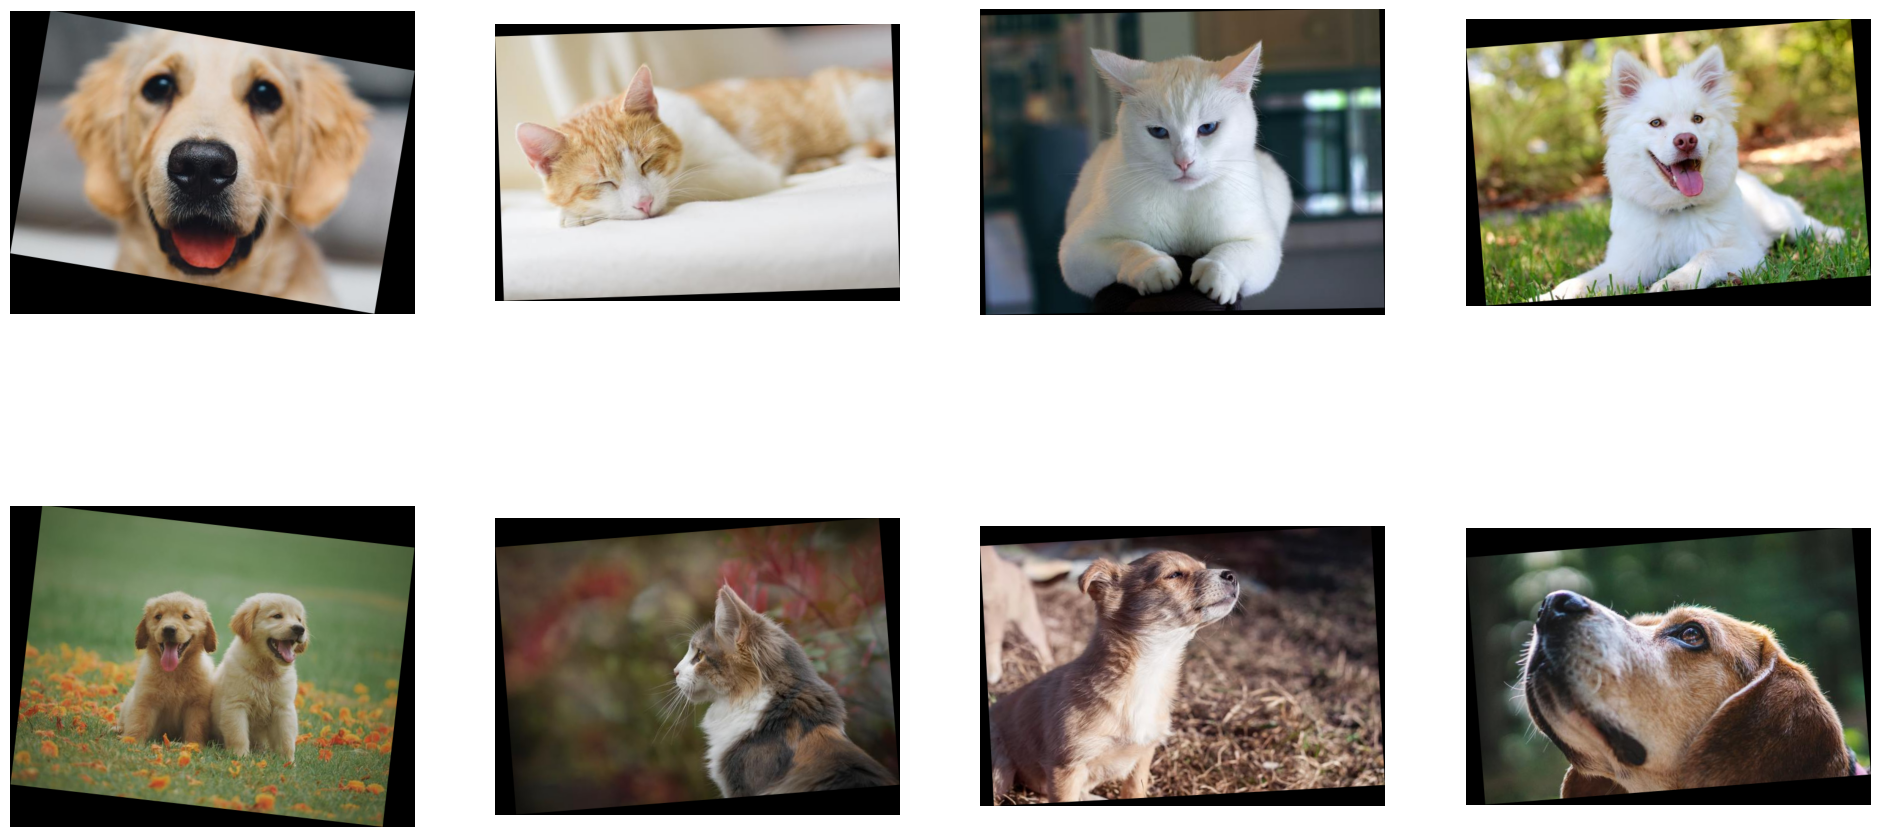

In [12]:
show_images(random_rotated_images.cpu())

### Hybrid Decoding

Sometimes, especially for higher resolution images, decoding images stored in JPEG format may become a bottleneck. To address this problem, nvJPEG and nvJPEG2000 libraries were developed. They split the decoding process between CPU and GPU, significantly reducing the decoding time.

Specifying `device="gpu"` in `ndd.decoders.image` enables nvJPEG and nvJPEG2000 support. Other file formats are still decoded on the CPU.

In [13]:
reader = ndd.readers.File(file_root=image_dir, random_shuffle=True, initial_fill=21)

for jpegs, labels in reader.next_epoch(batch_size=batch_size):
    images = ndd.decoders.image(jpegs, device="gpu")
    break

`ndd.decoders.image` with `device="gpu"` uses a hybrid approach of computation that employs both the CPU and the GPU. This means that it accepts CPU inputs, but returns GPU outputs. That is why `images` is a GPU batch.

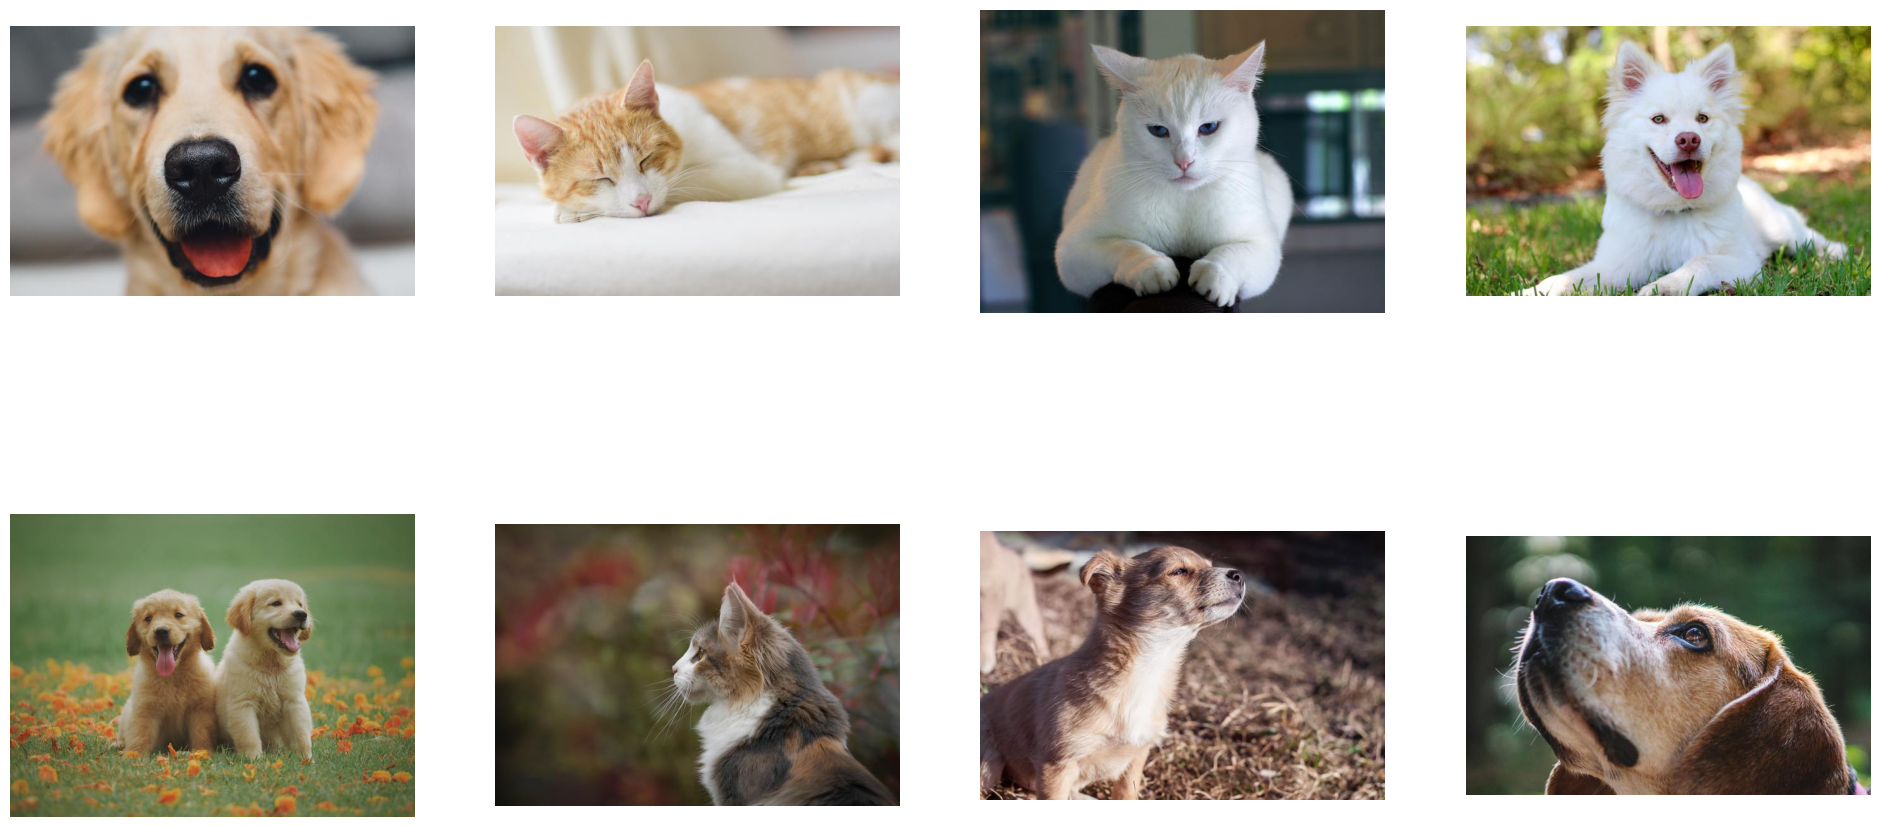

In [14]:
show_images(images.cpu())

Let us compare the speed of `ndd.decoders.image` for 'cpu' and 'gpu' backends with 4 CPU threads. We can use `ndd.EvalContext` to control the number of CPU threads.

<div class="alert alert-info">
    
  Note<br>
    
  By default, dynamic mode uses asynchronous execution: operations are scheduled to a background thread so calling a function is not blocking. This means that the output of `ndd.decoders.image` does not necessarily contain the decoded image after the execution of the function. When the data of a `Tensor` or `Batch` is requested, the `evaluate()` method is called under the hood to make sure to wait for the result to be ready.

  To ensure that the result gets evaluated right away, we can use `EvalMode.sync_full`.
</div>


In [15]:
import itertools
from timeit import default_timer as timer

test_batch_size = 64


def speedtest(device: str, batch_size: int, n_threads: int):
    reader = ndd.readers.File(
        file_root=image_dir,
        random_shuffle=True,
        initial_fill=21,
        pad_last_batch=True
    )
    
    with ndd.EvalContext(num_threads=n_threads), ndd.EvalMode.sync_full:
        # warmup
        for jpegs, _ in reader.next_epoch(batch_size=batch_size):
            ndd.decoders.image(jpegs, device=device)
                
        # test
        t_start = timer()
        n_test = 20
        i = 0
        for jpegs, _ in itertools.cycle(reader.next_epoch(batch_size=batch_size)):
            ndd.decoders.image(jpegs, device=device)
            i += 1
            if i >= n_test:
                break

    t = timer() - t_start    
    print("Speed: {} imgs/s".format((n_test * batch_size) / t))

In [16]:
speedtest('cpu', test_batch_size, 4)

Speed: 4013.5747883881863 imgs/s


In [17]:
speedtest('gpu', test_batch_size, 4)

Speed: 21784.753747678533 imgs/s


As we can see, using GPU accelerated decoding resulted in significant speedup.